<a href="https://colab.research.google.com/github/MMathisLab/CEBRA-demos/blob/main/CEBRA_best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best Practices for training CEBRA models

In this notebook, we show how to

- Use CEBRA-Time and CEBRA-Behavior.
- Perform a grid search.
- Perform train/validation splits.
- Run controls with shuffled data.
- Compute and display the consistency between runs.
- Check the loss functions.


In [ ]:
!pip install --pre 'cebra[datasets,integrations]'

In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

#for model saving:
import os
import tempfile
from pathlib import Path

# 1. Set up a CEBRA model

## Items to consider

- We recommend starting with an unsupervised approach (CEBRA-Time).
- We recommend starting with defaults, perform the sanity checks we suggest below, then performing a grid search if needed.
- We are going to largely follow the recommendations from our [Quick Start scikit-learn API](https://cebra.ai/docs/usage.html#quick-start-scikit-learn-api-example)

In [19]:
# 1. Define a CEBRA model
cebra_model = CEBRA(
    model_architecture="offset10-model", #consider: "offset10-model-mse" if Euclidean
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=5000, #we will sweep later; start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=3,
    distance='cosine', #consider 'euclidean'; if you set this, output_dimension min=2
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

# 2. Load the data

- (or adapt and use your data)
- We are going to use demo data. The data will be automatically downloaded into a `/data` folder.

In [ ]:
#2. example data
%mkdir data
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

### Visualize the data

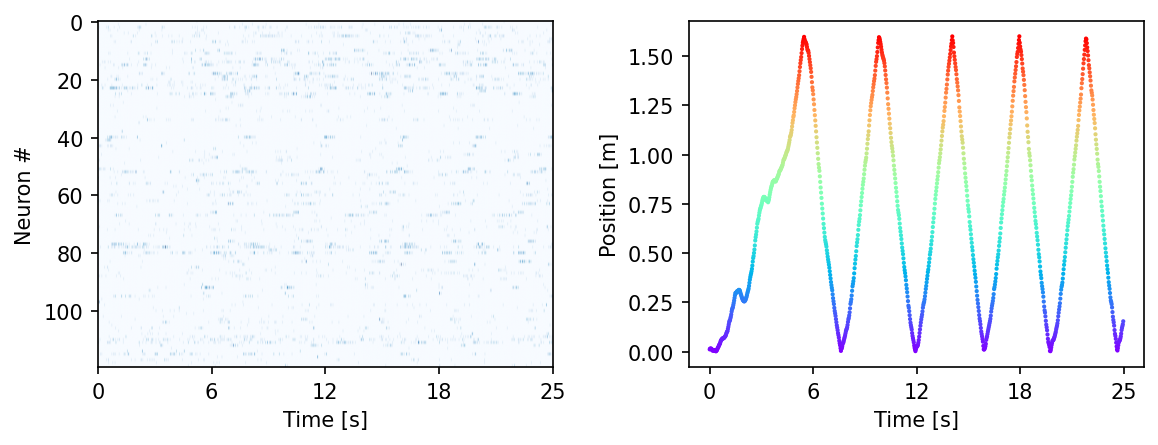

In [21]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'Blues')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000, 0],
            c=hippocampus_pos.continuous_index[:1000, 0], cmap='rainbow', s=1)

plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

# Quick test: Train CEBRA-Time on the full data (not train/validation yet)...

- This is a rapid quick start, just training without labels on the full dataset on the model we set up above! Here, we should already see a nice structured embedding.
- Note, the colors here are post-hoc applied; positional information was not used to train the model.

pos: -0.8521 neg:  6.3698 total:  5.5177 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 108.76it/s]
100%|██████████| 500/500 [00:01<00:00, 283.51it/s]

 GoF in bits - full: 1.0444026032825047


<Figure size 500x500 with 0 Axes>

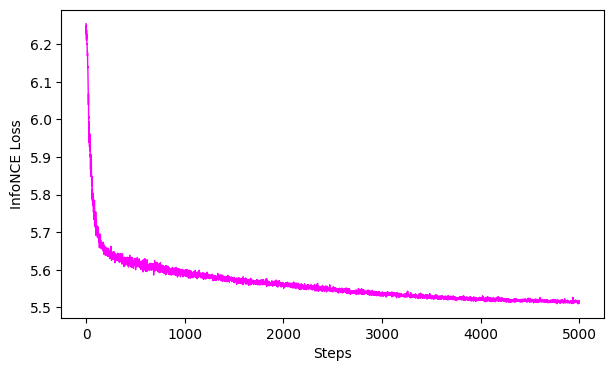

In [22]:
# fit
cebra_time_full_model = cebra_model.fit(hippocampus_pos.neural)
# transform
cebra_time_full = cebra_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model, hippocampus_pos.neural)
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_time_full, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Time (full)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_time_full_model)

# 3. Create a Train/Validation Split

- now that we know we get something decent (see structure, proper loss curve), we can properly test parameters.

In [23]:
# 3. Split data and labels
from sklearn.model_selection import train_test_split
split_idx = int(0.8 * len(hippocampus_pos.neural)) #suggest: 5%-20% depending on your dataset size

train_data = hippocampus_pos.neural[:split_idx]
valid_data = hippocampus_pos.neural[split_idx:]

train_continuous_label = hippocampus_pos.continuous_index.numpy()[:split_idx]
valid_continuous_label = hippocampus_pos.continuous_index.numpy()[split_idx:]


# 4. Fit the train split model

In [24]:
cebra_train_model = cebra_model.fit(train_data)#, train_continuous_label)

pos: -0.8541 neg:  6.3692 total:  5.5151 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.45it/s]


# 5. Save the model [optional]

In [25]:
tmp_file = Path(tempfile.gettempdir(), 'cebra.pt')
cebra_train_model.save(tmp_file)
#reload
cebra_train_model = cebra.CEBRA.load(tmp_file)

# 6. Compute (tranform) the embedding

In [26]:
train_embedding = cebra_train_model.transform(train_data)
valid_embedding = cebra_train_model.transform(valid_data)

# 7. Evaluate the Model
- Plot the loss curve
- We can also look at the Goodness of Fit this in bits vs. the infoNCE loss. [See more info here](https://cebra.ai/docs/api/sklearn/metrics.html#cebra.integrations.sklearn.metrics.goodness_of_fit_score)
 - ProTip: 0 bits would be a perfectly collapsed embedding.

100%|██████████| 500/500 [00:01<00:00, 285.95it/s]


 bits - train: 1.0405133889917533


100%|██████████| 500/500 [00:01<00:00, 288.75it/s]


 bits - valid: 0.3793706862907072


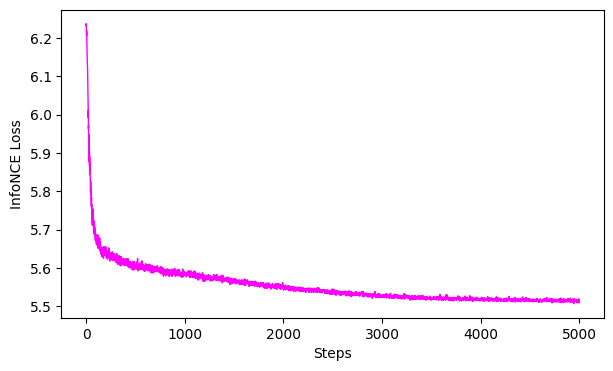

In [27]:
gof_train = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, train_data)
print(" bits - train:", gof_train)

gof_valid = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, valid_data)
gof_valid
print(" bits - valid:", gof_valid)

# plot the loss curve
ax = cebra.plot_loss(cebra_train_model)

## Visualize the embeddings

- train, then validation

In [28]:
import cebra.integrations.plotly
#train
fig = cebra.integrations.plotly.plot_embedding_interactive(train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "CEBRA-Time Train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

#validation
fig = cebra.integrations.plotly.plot_embedding_interactive(valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "CEBRA-Time-validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# Next sanity/validation step: Consistency

What did we check above?
 - (1) do we see structure in our embedding? (if not, something is off!)
 - (2) is the GoF reasonable? (infoNCE low, bits high)
 - (3) Is the loss converging without overfitting (no sudden drop after many interations?)

IF 1-3 are not satisfactory, skip to the **Grid Search Below!**

Beyond these being met, we need to check the consistency across runs! In addition to the above checks, once we have a converging model that produces **consistent embeddings**, then we know we have good model parameters! 🚀

In [29]:
# Now we are going to run our train/val. 10 times to be sure they are consistent!

X = 10  # Number of training runs
model_paths = []  # Store file paths

for i in range(X):
    print(f"Training 🦓CEBRA model {i+1}/{X}")

    # Train and save model
    cebra_train_model = cebra_model.fit(train_data)
    tmp_file = Path(tempfile.gettempdir(), f'cebra_{i}.pt')
    cebra_train_model.save(tmp_file)
    model_paths.append(tmp_file)

# Reload models and transform data
train_embeddings = []
valid_embeddings = []

for tmp_file in model_paths:
    cebra_train_model = cebra.CEBRA.load(tmp_file)
    train_embeddings.append(cebra_train_model.transform(train_data))
    valid_embeddings.append(cebra_train_model.transform(valid_data))

Training iteration 1/10


pos: -0.8540 neg:  6.3702 total:  5.5161 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.78it/s]


Training iteration 2/10


pos: -0.8440 neg:  6.3723 total:  5.5283 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.19it/s]


Training iteration 3/10


pos: -0.8485 neg:  6.3677 total:  5.5191 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.79it/s]


Training iteration 4/10


pos: -0.8500 neg:  6.3694 total:  5.5194 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.26it/s]


Training iteration 5/10


pos: -0.8492 neg:  6.3708 total:  5.5216 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.22it/s]


Training iteration 6/10


pos: -0.8573 neg:  6.3699 total:  5.5126 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.42it/s]


Training iteration 7/10


pos: -0.8522 neg:  6.3713 total:  5.5191 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.63it/s]


Training iteration 8/10


pos: -0.8519 neg:  6.3684 total:  5.5165 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.58it/s]


Training iteration 9/10


pos: -0.8508 neg:  6.3683 total:  5.5176 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.28it/s]


Training iteration 10/10


pos: -0.8493 neg:  6.3720 total:  5.5227 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.36it/s]


### Compute Consistency Across Runs
- Now that we have 10 runs of train, we can compute the consistency between runs.
- TRAIN: This should be high (in the 90's on the train embeddings)!
- VALID: Depending on how large your validation data are, this also should be as high.
 - In our demo data, the cebra-time on rat 1 with 20% held out is in the 70's for 5K iterations, which is acceptable.

<Axes: >

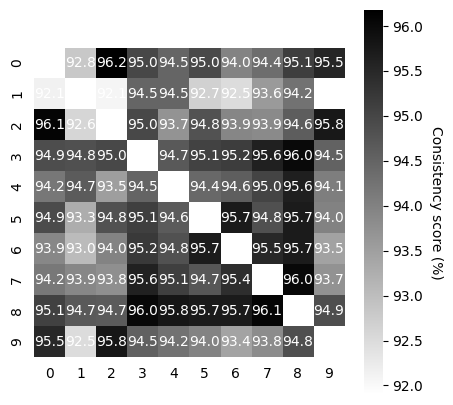

In [33]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=train_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

<Axes: >

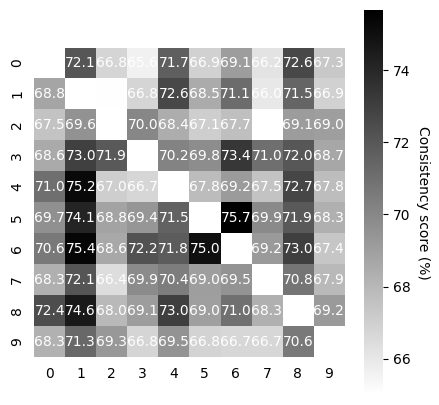

In [34]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=valid_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

# What if I don't have good parameters? Let's do a grid search...

In [ ]:
#%mkdir saved_models

params_grid = dict(
    output_dimension = [3, 8],
    time_offsets = [10, 20],
    model_architecture='offset10-model',
    temperature_mode='constant',
    temperature=[0.1, 1.0],
    max_iterations=[1000, 5000],
    device='cuda_if_available',
    num_hidden_units = [32, 64],
    verbose = True)

datasets = {"dataset1": train_data}
# run the grid search
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets, params=params_grid, models_dir="saved_models")

pos: -9.2690 neg:  16.1433 total:  6.8742 temperature:  0.1000: 100%|██████████| 1000/1000 [00:07<00:00, 136.67it/s]
pos: -9.0575 neg:  16.5190 total:  7.4616 temperature:  0.1000: 100%|██████████| 1000/1000 [00:07<00:00, 137.87it/s]
pos: -0.9301 neg:  9.1746 total:  8.2444 temperature:  1.0000: 100%|██████████| 1000/1000 [00:07<00:00, 138.04it/s]
pos: -0.8930 neg:  9.1791 total:  8.2861 temperature:  1.0000: 100%|██████████| 1000/1000 [00:07<00:00, 138.03it/s]
pos: -8.7004 neg:  13.8898 total:  5.1894 temperature:  0.1000: 100%|██████████| 1000/1000 [00:07<00:00, 139.32it/s]
pos: -8.2031 neg:  14.1089 total:  5.9059 temperature:  0.1000: 100%|██████████| 1000/1000 [00:07<00:00, 140.19it/s]
pos: -0.9265 neg:  9.1521 total:  8.2256 temperature:  1.0000: 100%|██████████| 1000/1000 [00:07<00:00, 140.61it/s]
pos: -0.9014 neg:  9.1807 total:  8.2793 temperature:  1.0000: 100%|██████████| 1000/1000 [00:07<00:00, 140.54it/s]
pos: -9.5479 neg:  16.0551 total:  6.5072 temperature:  0.1000: 100%

In [ ]:
# Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")

# Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name=datasets, models_dir="saved_models")